In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import category_encoders as ce

from sklearn.tree import _tree
from sklearn import tree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing  import  StandardScaler
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

## 1 - Engenharia de features

In [78]:
#nome das colunas
columns_cred = ['ESCT','NDEP','RENDA','TIPOR','VBEM','NPARC','VPARC','TEL','IDADE','RESMS','ENTRADA','CLASSE']

In [79]:
#leitura dos dados
raw_train = pd.read_csv('../dados/credtrain.txt',sep = '\t', header=None, names = columns_cred)
raw_test = pd.read_csv('../dados/credtest.txt',sep = '\t', header=None, names = columns_cred)

In [80]:
#lower nas colunas pra melhor manipulação
raw_train.columns = [x.lower() for x in raw_train.columns]
raw_test.columns = [x.lower() for x in raw_test.columns]

In [81]:
df_train = raw_train.copy()
df_test = raw_test.copy()

In [82]:
df_train.head()

,esct,ndep,renda,tipor,vbem,nparc,vparc,tel,idade,resms,entrada,classe
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   esct     1500 non-null   int64
 1   ndep     1500 non-null   int64
 2   renda    1500 non-null   int64
 3   tipor    1500 non-null   int64
 4   vbem     1500 non-null   int64
 5   nparc    1500 non-null   int64
 6   vparc    1500 non-null   int64
 7   tel      1500 non-null   int64
 8   idade    1500 non-null   int64
 9   resms    1500 non-null   int64
 10  entrada  1500 non-null   int64
 11  classe   1500 non-null   int64
dtypes: int64(12)
memory usage: 140.8 KB


In [84]:
df_train.classe.value_counts()

classe
0    785
1    715
Name: count, dtype: int64

### Preparação pro fit

Selecionando variáveis que precisam ser normalizadas e que precisam ser categorizadas

In [85]:
#separando variáveis
target = ['classe']

#standard scaler
dep_to_scaler = ['renda', 'vbem', 'nparc', 'vparc','idade', 'resms', 'entrada']

#count encoder
dep_to_count_encoder = ['tipor','tel']

#quantile encoder
dep_to_quantile = ['esct']

#grey encoder
dep_to_james = ['ndep']

In [86]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler].join(df_train[dep_to_count_encoder]).join(df_train[dep_to_quantile]).join(df_train[dep_to_james])
X_test = df_test[dep_to_scaler].join(df_test[dep_to_count_encoder]).join(df_test[dep_to_quantile]).join(df_test[dep_to_james])

In [87]:
X_train.shape, X_test.shape

((1500, 11), (577, 11))

Padronização dos dados

In [88]:
#TRANFORMER DEPOIS DO SPLIT PRA NÃO VAZAR DADOS DO TREINO PRO TESTE

#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

Encoder nas categóricas

Aqui vamos utilizar 3 métodos de encoder:  

Count Encoder: Substitui os nomes dos grupos pelas contagens dos grupos para um determinado recurso categórico. Esse método será usado para a variável 'tipo de residência' e 'possui telefone'.  
Quantile Encoder: Recursos selecionados são substituídos pelo quantil estatístico. Esse método será usado para a variável 'estado civil'.   
James Stein Encoder: Retorna uma média ponderada do valor alvo médio para o valor do recurso observado i. Esse método será usado para a variável 'número de dependentes'.

In [89]:
#encoding
count_encoder = ce.CountEncoder(cols=dep_to_count_encoder)
quant_encoder = ce.quantile_encoder.QuantileEncoder(cols=dep_to_quantile)
james_encoder = ce.james_stein.JamesSteinEncoder(cols=dep_to_james)

In [90]:
#fit nos dados de treino e transform nos dados de teste
X_train = count_encoder.fit_transform(X_train)
X_train = quant_encoder.fit_transform(X_train, y_train)
X_train = james_encoder.fit_transform(X_train, y_train)

X_test = count_encoder.transform(X_test)
X_test = quant_encoder.transform(X_test, y_test)
X_test = james_encoder.transform(X_test, y_test)

In [91]:
X_train.head()

,renda,vbem,nparc,vparc,idade,resms,entrada,tipor,tel,esct,ndep
0,-0.689892,-0.937611,0.168333,-0.798003,-1.228280,0.312878,-0.342137,832,1299,0.998339,0.483223
1,-0.700939,-0.354031,0.445500,-0.591544,-0.622121,-0.484925,-0.342137,668,1299,0.000000,0.483223
2,0.127578,1.005145,0.168333,0.361347,1.120585,0.312878,-0.342137,832,1299,0.000000,0.483223
3,2.226490,-0.037768,0.999835,-0.416847,-0.773661,0.540822,-0.342137,832,201,0.000000,0.483223
4,0.017109,0.929845,0.999835,0.139006,-1.304049,-0.465930,-0.342137,832,1299,0.998339,0.483223


Gradient Boosting

In [92]:
clf = GradientBoostingClassifier(random_state = 1) 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       306
           1       0.97      0.83      0.90       271

    accuracy                           0.91       577
   macro avg       0.92      0.91      0.91       577
weighted avg       0.92      0.91      0.91       577



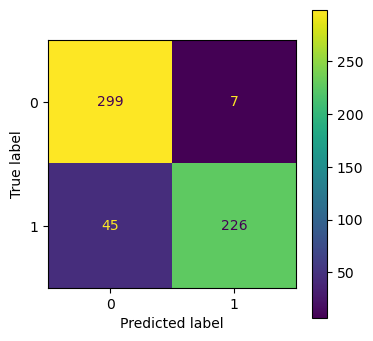

In [99]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

Comparando com o modelo escolhido para o problema no trabalho 1 (Gradient Boosting), e utilizando esses novos métodos de encoder para variáveis categóricas, tivemos um ganho de 2p.p. de precisão da classe 1, indo saindo de 95% para 97%.

## 2 - Validação cruzada

In [142]:
def to_binary(my_array):
    '''tranforma todos os valores do array que são diferentes de 0 em 1'''
    my_array[my_array != 0] = 1
    return my_array

### Conjunto 1

In [260]:
with open("../dados/A602.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [144]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [145]:
#unindo verticalmente arrays de treino e validação

X_to_cv = np.vstack((X_train, X_val))
y_to_cv = np.vstack((y_train, y_val))

In [146]:
clf = GradientBoostingClassifier(random_state=1)

Selecionando parâmetros para serem testados no GridSearch com cross-validation para encontrar melhor modelo

In [147]:
#hiperparâmetos a serem explorados

param_grid = {
    'loss': ['log_loss', 'exponential']
    ,'n_estimators': [100,200,300]
    ,'max_depth': [4,5,6]
    ,'max_features': ['sqrt', 'log2']
}

Importante saber:

loss - função a ser otimizada;  
n_estimators - número de estágios de reforço a serem executados;   
max_depth - profundidade máxima dos estimadores de regressão individuais;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  

In [148]:
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = stratkf, scoring='precision')
grid.fit(X_to_cv, y_to_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='precision')

In [149]:
#melhor modelo

grid.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='sqrt',
                           random_state=1)

In [150]:
rfg_grid = grid.best_estimator_

rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [151]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       673
         1.0       0.55      0.51      0.53        92

    accuracy                           0.89       765
   macro avg       0.74      0.73      0.73       765
weighted avg       0.89      0.89      0.89       765



A precisão pra classe 1 foi de 48% para 55%, ganho de 7.p.p., quando comparado com o modelo defalut treinado no trabalho 1.

### Conjunto 2

In [152]:
with open("../dados/A621.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [153]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [154]:
#unindo verticalmente arrays de treino e validação

X_to_cv = np.vstack((X_train, X_val))
y_to_cv = np.vstack((y_train, y_val))

In [155]:
clf = GradientBoostingClassifier(random_state=1)

Selecionando parâmetros para serem testados no GridSearch com cross-validation para encontrar melhor modelo

In [156]:
#hiperparâmetos a serem explorados

param_grid = {
    'loss': ['log_loss', 'exponential']
    ,'n_estimators': [100,200,300]
    ,'max_depth': [4,5,6]
    ,'max_features': ['sqrt', 'log2']
}

Importante saber:

loss - função a ser otimizada;  
n_estimators - número de estágios de reforço a serem executados;   
max_depth - profundidade máxima dos estimadores de regressão individuais;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  

In [157]:
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = stratkf, scoring='precision')
grid.fit(X_to_cv, y_to_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='precision')

In [158]:
#melhor modelo

grid.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features='sqrt',
                           random_state=1)

In [159]:
rfg_grid = grid.best_estimator_

rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      9147
         1.0       0.69      0.47      0.56       933

    accuracy                           0.93     10080
   macro avg       0.82      0.72      0.76     10080
weighted avg       0.92      0.93      0.93     10080



A precisão pra classe 1 foi de 61% para 69%, ganho de 8.p.p., quando comparado com o modelo defalut treinado no trabalho 1.

### Conjunto 3

In [161]:
with open("../dados/A627.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [162]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [163]:
#unindo verticalmente arrays de treino e validação

X_to_cv = np.vstack((X_train, X_val))
y_to_cv = np.vstack((y_train, y_val))

In [164]:
clf = GradientBoostingClassifier(random_state=1)

Selecionando parâmetros para serem testados no GridSearch com cross-validation para encontrar melhor modelo

In [165]:
#hiperparâmetos a serem explorados

param_grid = {
    'loss': ['log_loss', 'exponential']
    ,'n_estimators': [100,200,300]
    ,'max_depth': [4,5,6]
    ,'max_features': ['sqrt', 'log2']
}

Importante saber:

loss - função a ser otimizada;  
n_estimators - número de estágios de reforço a serem executados;   
max_depth - profundidade máxima dos estimadores de regressão individuais;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  

In [166]:
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = stratkf, scoring='precision')
grid.fit(X_to_cv, y_to_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='precision')

In [167]:
#melhor modelo

grid.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='sqrt',
                           random_state=1)

In [168]:
rfg_grid = grid.best_estimator_

rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [169]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      9200
         1.0       0.70      0.53      0.60      1002

    accuracy                           0.93     10202
   macro avg       0.82      0.75      0.78     10202
weighted avg       0.93      0.93      0.93     10202



A precisão pra classe 1 foi de 68% para 70%, ganho de 2.p.p., quando comparado com o modelo defalut treinado no trabalho 1.

### Conjunto 4

In [170]:
with open("../dados/A636.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [171]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [172]:
#unindo verticalmente arrays de treino e validação

X_to_cv = np.vstack((X_train, X_val))
y_to_cv = np.vstack((y_train, y_val))

In [173]:
clf = GradientBoostingClassifier(random_state=1)

Selecionando parâmetros para serem testados no GridSearch com cross-validation para encontrar melhor modelo

In [174]:
#hiperparâmetos a serem explorados

param_grid = {
    'loss': ['log_loss', 'exponential']
    ,'n_estimators': [100,200,300]
    ,'max_depth': [4,5,6]
    ,'max_features': ['sqrt', 'log2']
}

Importante saber:

loss - função a ser otimizada;  
n_estimators - número de estágios de reforço a serem executados;   
max_depth - profundidade máxima dos estimadores de regressão individuais;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  

In [176]:
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = stratkf, scoring='precision')
grid.fit(X_to_cv, y_to_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='precision')

In [177]:
#melhor modelo

grid.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=6, max_features='sqrt',
                           random_state=1)

In [178]:
rfg_grid = grid.best_estimator_

rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      9017
         1.0       0.68      0.53      0.59      1112

    accuracy                           0.92     10129
   macro avg       0.81      0.75      0.77     10129
weighted avg       0.91      0.92      0.92     10129



A precisão pra classe 1 foi de 67% para 68%, ganho de 1.p.p., quando comparado com o modelo default treinado no trabalho 1.

### Conjunto 5

In [180]:
with open("../dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [181]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [182]:
#unindo verticalmente arrays de treino e validação

X_to_cv = np.vstack((X_train, X_val))
y_to_cv = np.vstack((y_train, y_val))

In [183]:
clf = GradientBoostingClassifier(random_state=1)

Selecionando parâmetros para serem testados no GridSearch com cross-validation para encontrar melhor modelo

In [184]:
#hiperparâmetos a serem explorados

param_grid = {
    'loss': ['log_loss', 'exponential']
    ,'n_estimators': [100,200,300]
    ,'max_depth': [4,5,6]
    ,'max_features': ['sqrt', 'log2']
}

Importante saber:

loss - função a ser otimizada;  
n_estimators - número de estágios de reforço a serem executados;   
max_depth - profundidade máxima dos estimadores de regressão individuais;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  

In [185]:
stratkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = stratkf, scoring='precision')
grid.fit(X_to_cv, y_to_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'loss': ['log_loss', 'exponential'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='precision')

In [186]:
#melhor modelo

grid.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=5, max_features='sqrt',
                           n_estimators=300, random_state=1)

In [187]:
rfg_grid = grid.best_estimator_

rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [188]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      8769
         1.0       0.77      0.31      0.45       813

    accuracy                           0.93      9582
   macro avg       0.86      0.65      0.71      9582
weighted avg       0.93      0.93      0.92      9582



A precisão pra classe 1 foi de 75% para 77%, ganho de 2.p.p., quando comparado com o modelo default treinado no trabalho 1.

## 3 - Classificação multi-classes

In [3]:
def to_multi_class(my_array):
    '''discretiza o y em 1,2,3,4,5'''
    my_array[my_array == 0] = 0
    my_array[(my_array > 0) & (my_array <= 5)] = 1
    my_array[(my_array > 5) & (my_array <= 25)] = 2
    my_array[(my_array > 25) & (my_array <= 50)] = 3
    my_array[my_array > 50] = 4
    return my_array

### Conjunto 1

In [125]:
with open("../dados/A602.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [126]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [127]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo

X_to_es = np.vstack((X_train, X_val))
y_to_es = np.vstack((y_train, y_val))

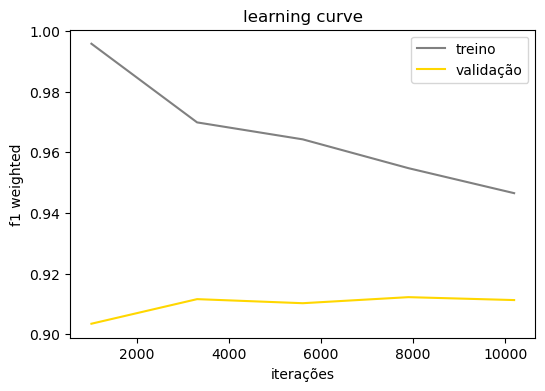

In [128]:
clf = GradientBoostingClassifier(random_state=1)

# curva de aprendizado
cv = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'

train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_to_es, y_to_es, scoring=scoring,cv=cv)

# plotando
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), label='treino', c='grey')
plt.plot(train_sizes_abs, np.mean(test_scores, axis=1), label='validação', c='gold')
plt.xlabel('iterações')
plt.ylabel('f1 weighted')
plt.title('learning curve')
plt.legend()
plt.show()

In [129]:
# modelo com parada antecipada
n_estimators = 100
validation_fraction = 0.2
n_iter_no_change = 10
tol = 0.01

clf = GradientBoostingClassifier(n_estimators=n_estimators,
                                 validation_fraction=validation_fraction,
                                 n_iter_no_change=n_iter_no_change, 
                                 tol=tol,
                                 random_state=1)

modelo = clf.fit(X_to_es, y_to_es)
y_pred = modelo.predict(X_test)

In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       673
         1.0       0.48      0.42      0.45        83
         2.0       0.08      0.11      0.09         9
         3.0       0.00      0.00      0.00         0

    accuracy                           0.87       765
   macro avg       0.37      0.37      0.37       765
weighted avg       0.88      0.87      0.87       765



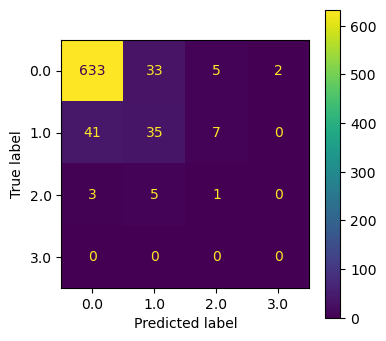

In [131]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

No trabalho 1 realizamos a predição para um problema de classificação binária, e aqui estamos olhando para um problema multi-classe, com base no mesmo conjunto de dados. Comparando a acurácia das duas abordagens temos uma estabilidade de 87%.

### Conjunto 2

In [155]:
with open("../dados/A621.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [156]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [157]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo

X_to_es = np.vstack((X_train, X_val))
y_to_es = np.vstack((y_train, y_val))

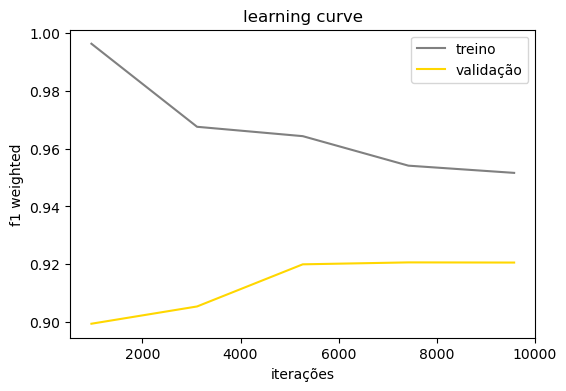

In [158]:
clf = GradientBoostingClassifier(random_state=1)

# curva de aprendizado
cv = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'

train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_to_es, y_to_es, scoring=scoring,cv=cv)

# plotando
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), label='treino', c='grey')
plt.plot(train_sizes_abs, np.mean(test_scores, axis=1), label='validação', c='gold')
plt.xlabel('iterações')
plt.ylabel('f1 weighted')
plt.title('learning curve')
plt.legend()
plt.show()

In [159]:
# modelo com parada antecipada
n_estimators = 100
validation_fraction = 0.2
n_iter_no_change = 10
tol = 0.01

clf = GradientBoostingClassifier(n_estimators=n_estimators,
                                 validation_fraction=validation_fraction,
                                 n_iter_no_change=n_iter_no_change, 
                                 tol=tol,
                                 random_state=1)

modelo = clf.fit(X_to_es, y_to_es)
y_pred = modelo.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      9147
         1.0       0.66      0.38      0.49       848
         2.0       0.00      0.00      0.00        75
         3.0       0.29      0.22      0.25         9
         4.0       0.00      0.00      0.00         1

    accuracy                           0.93     10080
   macro avg       0.38      0.32      0.34     10080
weighted avg       0.91      0.93      0.92     10080



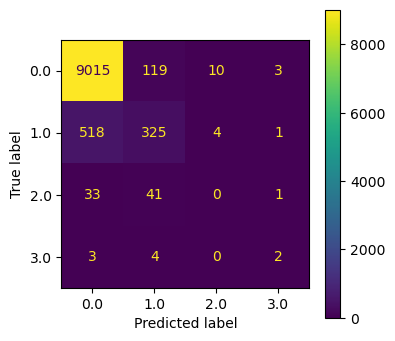

In [161]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

No trabalho 1 realizamos a predição para um problema de classificação binária, e aqui estamos olhando para um problema multi-classe, com base no mesmo conjunto de dados. Comparando a acurácia das duas abordagens temos uma estabilidade de 93%.

### Conjunto 3

In [162]:
with open("../dados/A627.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [163]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [164]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo

X_to_es = np.vstack((X_train, X_val))
y_to_es = np.vstack((y_train, y_val))

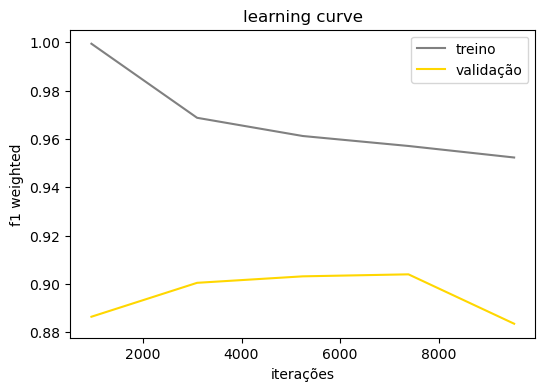

In [173]:
clf = GradientBoostingClassifier(random_state=1)

# curva de aprendizado
cv = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'

train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_to_es, y_to_es, scoring=scoring,cv=cv)

# plotando
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), label='treino', c='grey')
plt.plot(train_sizes_abs, np.mean(test_scores, axis=1), label='validação', c='gold')
plt.xlabel('iterações')
plt.ylabel('f1 weighted')
plt.title('learning curve')
plt.legend()
plt.show()

Não foi possível o treino com parada antecipada para esse conjunto pois a classe 4 do conjunto tem tamanho 1.

In [174]:
modelo = clf.fit(X_to_es, y_to_es)
y_pred = modelo.predict(X_test)

In [175]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      9200
         1.0       0.62      0.39      0.48       921
         2.0       0.13      0.17      0.15        75
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00         0

    accuracy                           0.92     10202
   macro avg       0.34      0.31      0.32     10202
weighted avg       0.91      0.92      0.91     10202



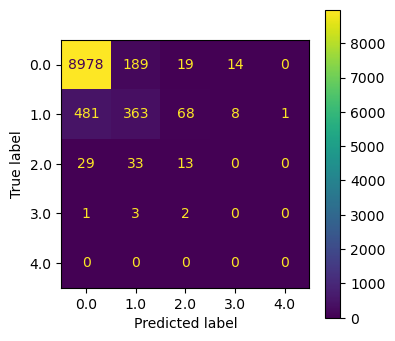

In [176]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

No trabalho 1 realizamos a predição para um problema de classificação binária, e aqui estamos olhando para um problema multi-classe, com base no mesmo conjunto de dados. Comparando a acurácia das duas abordagens temos uma diminuição de 1p.p. para 92%.

### Conjunto 4

In [177]:
with open("../dados/A636.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [178]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [179]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo

X_to_es = np.vstack((X_train, X_val))
y_to_es = np.vstack((y_train, y_val))

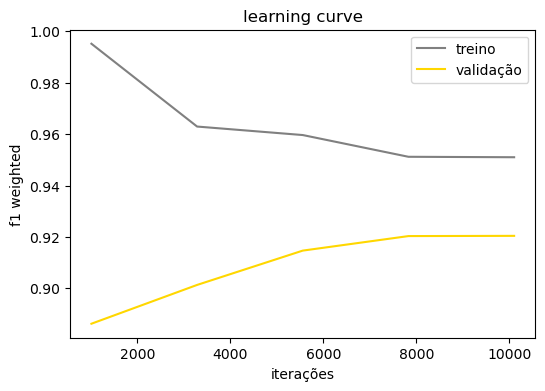

In [180]:
clf = GradientBoostingClassifier(random_state=1)

# curva de aprendizado
cv = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'

train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_to_es, y_to_es, scoring=scoring,cv=cv)

# plotando
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), label='treino', c='grey')
plt.plot(train_sizes_abs, np.mean(test_scores, axis=1), label='validação', c='gold')
plt.xlabel('iterações')
plt.ylabel('f1 weighted')
plt.title('learning curve')
plt.legend()
plt.show()

In [181]:
# modelo com parada antecipada
n_estimators = 100
validation_fraction = 0.2
n_iter_no_change = 10
tol = 0.01

clf = GradientBoostingClassifier(n_estimators=n_estimators,
                                 validation_fraction=validation_fraction,
                                 n_iter_no_change=n_iter_no_change, 
                                 tol=tol,
                                 random_state=1)

modelo = clf.fit(X_to_es, y_to_es)
y_pred = modelo.predict(X_test)

In [182]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      9017
         1.0       0.65      0.42      0.51       992
         2.0       0.27      0.15      0.20       110
         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00         1

    accuracy                           0.91     10129
   macro avg       0.37      0.31      0.33     10129
weighted avg       0.90      0.91      0.91     10129



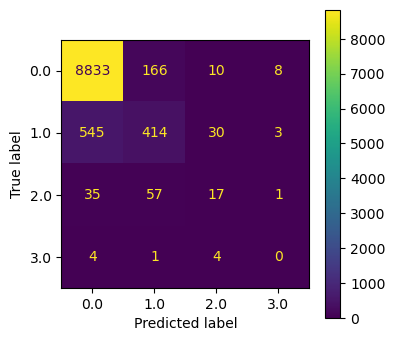

In [183]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

No trabalho 1 realizamos a predição para um problema de classificação binária, e aqui estamos olhando para um problema multi-classe, com base no mesmo conjunto de dados. Comparando a acurácia das duas abordagens temos diminuição de 1p.p. para 91%.

### Conjunto 5

In [184]:
with open("../dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [185]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [186]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo

X_to_es = np.vstack((X_train, X_val))
y_to_es = np.vstack((y_train, y_val))

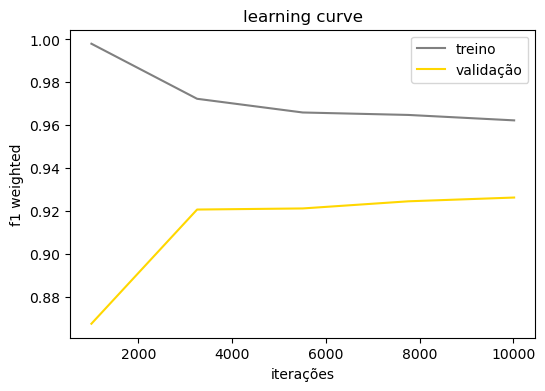

In [187]:
clf = GradientBoostingClassifier(random_state=1)

# curva de aprendizado
cv = StratifiedKFold(n_splits=5)
scoring = 'f1_weighted'

train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_to_es, y_to_es, scoring=scoring,cv=cv)

# plotando
plt.figure(figsize=(6, 4))
plt.plot(train_sizes_abs, np.mean(train_scores, axis=1), label='treino', c='grey')
plt.plot(train_sizes_abs, np.mean(test_scores, axis=1), label='validação', c='gold')
plt.xlabel('iterações')
plt.ylabel('f1 weighted')
plt.title('learning curve')
plt.legend()
plt.show()

In [188]:
# modelo com parada antecipada
n_estimators = 100
validation_fraction = 0.2
n_iter_no_change = 10
tol = 0.01

clf = GradientBoostingClassifier(n_estimators=n_estimators,
                                 validation_fraction=validation_fraction,
                                 n_iter_no_change=n_iter_no_change, 
                                 tol=tol,
                                 random_state=1)

modelo = clf.fit(X_to_es, y_to_es)
y_pred = modelo.predict(X_test)

In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.74      0.28      0.40       757
         2.0       0.08      0.04      0.05        50
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         2

    accuracy                           0.93      9582
   macro avg       0.35      0.26      0.28      9582
weighted avg       0.92      0.93      0.92      9582



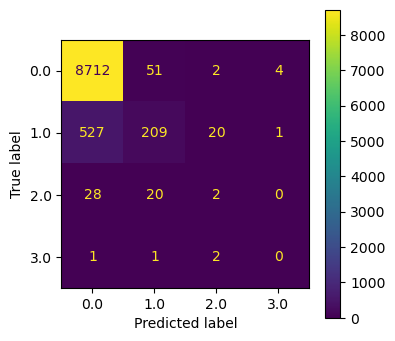

In [190]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_
                             )
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
plt.show()

No trabalho 1 realizamos a predição para um problema de classificação binária, e aqui estamos olhando para um problema multi-classe, com base no mesmo conjunto de dados. Comparando a acurácia das duas abordagens temos diminuição de 1p.p. para 93%.

## 4 - SHAP Values

Nessa seção, após ajustar um modelo de classificação aos dados, vamos avaliar o shap values das variáveis, que basicamente são valores que ajudam a explicar a saída de um modelo de aprendizado de máquina, indicando a contribuição de cada característica para a predição de uma instância específica.  

Iremos avaliar:

a) Análise global: através do summary_plot podemos ver a contribuição média de cada feature e permite identificar quais características têm um impacto mais significativo nas previsões do modelo para cada classe.  

b) A análise global também será feita pelo shap.plots.bar em que é possível identificar a direção da força (em média) das features.  

c) Análise local: iremos avaliar como se dão as contribuições das variáveis para uma instância específica.  

d) Beeswarm: O gráfico de beeswarm mostra a densidade de pontos para cada valor SHAP ao longo do eixo y. Isso permite ver como os valores SHAP se distribuiem em relação aos valores das variáveis.  

Essas análises serão feitas para todos os conjuntos.

In [3]:
def to_multi_class_columun(df, column_name, column_name_padro):
    '''discretiza o y em 0,1,2,3,4'''
    df[column_name_padro] = np.nan
    df.loc[df[column_name] == 0, column_name_padro] = 0
    df.loc[((df[column_name] > 0) & (df[column_name] <= 5)), column_name_padro] = 1
    df.loc[((df[column_name] > 5) & (df[column_name] <= 25)), column_name_padro] = 2
    df.loc[((df[column_name] > 25) & (df[column_name] <= 50)), column_name_padro] = 3
    df.loc[(df[column_name] > 50), column_name_padro] = 4
    return df

### Conjunto 1

In [109]:
#lendo os dados

path = "../dados/A602_train.parquet.gzip"

train = pd.read_parquet(path)
val = pd.read_parquet(path)
test = pd.read_parquet(path)

In [110]:
#aplicando função de discretização
df_train = to_multi_class_columun(train, 'precipitation', 'p_padro')
df_val = to_multi_class_columun(val, 'precipitation', 'p_padro')
df_test = to_multi_class_columun(test, 'precipitation', 'p_padro')

In [111]:
#unindo treino e validação
df_train = pd.concat([df_train, df_val])

Preparação pro fit

In [112]:
#separando variáveis
target = ['p_padro']

dep_to_scaler = df_train.columns.drop(['precipitation', 'p_padro'])

In [113]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler]
X_test = df_test[dep_to_scaler]

In [114]:
X_train.shape, X_test.shape

((20560, 7), (10280, 7))

Padronização dos dados

In [115]:
#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [116]:
rfg = RandomForestClassifier(random_state=1)

rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

#### SHAP values

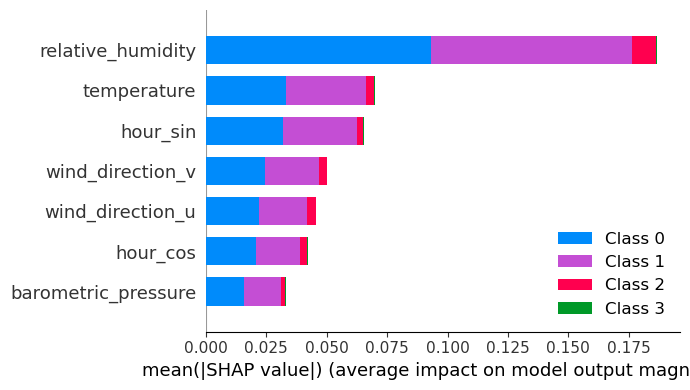

In [117]:
#análise global por classe
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=15, plot_size=(7, 4))

O gráfico acima sugere a feature relative_humidity como vaiável mais relevante pro modelo, pois é a que apresenta mais contribuições para as classes.

In [118]:
#amostrando X para agilizar algumas análises
amostra = int(len(X_train) * 0.2)

sample_x = X_train.sample(amostra)

ExactExplainer explainer: 4113it [05:01, 13.17it/s]                          


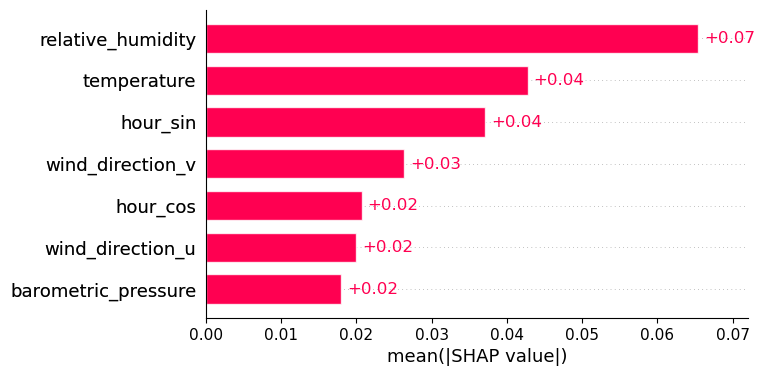

In [119]:
#análise global
explainer = shap.Explainer(rfg.predict, sample_x)
shap_values = explainer(sample_x)
shap.plots.bar(shap_values, max_display=15, show=False)

fig = plt.gcf().set_size_inches(7, 4)
#fig.patch.set_facecolor('white')
plt.show()

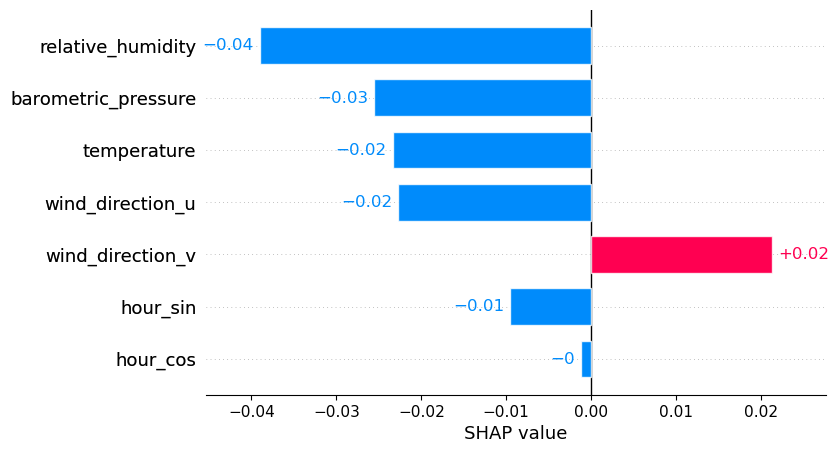

In [120]:
#análise individual de uma predição específica
shap.plots.bar(shap_values[0], max_display=15, show=False)

O que chama atenção aqui, é que para essa predição em específico, a maioria das variáveis tiveram contribuições negativas.

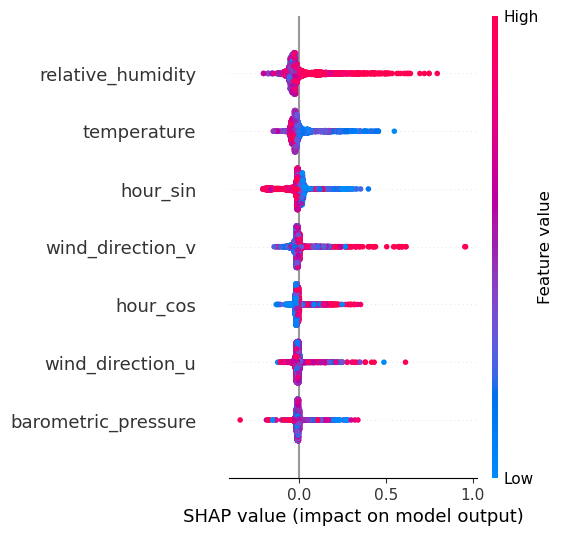

In [121]:
shap.plots.beeswarm(shap_values, show=False, plot_size=(4, 6))

Através do beeswarm percebemos que para valores altos de relative_humidity maiores são as contribuições positivas da variável.

### Conjunto 2

In [40]:
#lendo os dados

path = "../dados/A621_train.parquet.gzip"

train = pd.read_parquet(path)
val = pd.read_parquet(path)
test = pd.read_parquet(path)

In [41]:
#aplicando função de discretização
df_train = to_multi_class_columun(train, 'precipitation', 'p_padro')
df_val = to_multi_class_columun(val, 'precipitation', 'p_padro')
df_test = to_multi_class_columun(test, 'precipitation', 'p_padro')

In [42]:
#unindo treino e validação
df_train = pd.concat([df_train, df_val])

Preparação pro fit

In [43]:
#separando variáveis
target = ['p_padro']

dep_to_scaler = df_train.columns.drop(['precipitation', 'p_padro'])

In [44]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler]
X_test = df_test[dep_to_scaler]

In [45]:
X_train.shape, X_test.shape

((19472, 7), (9736, 7))

Padronização dos dados

In [46]:
#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [47]:
rfg = RandomForestClassifier(random_state=1)

rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

#### SHAP values

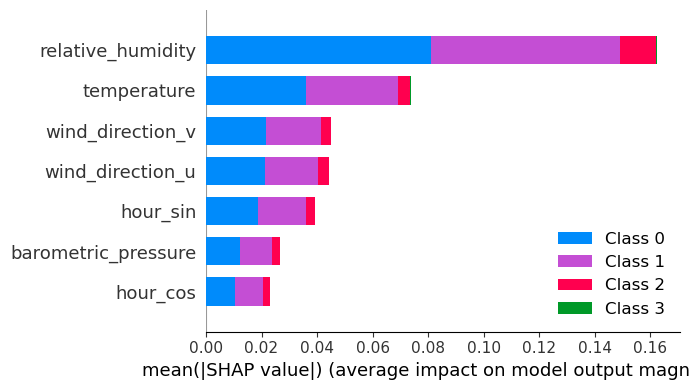

In [96]:
#análise global por classe
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=15, plot_size=(7, 4))

O gráfico acima também sugere a feature relative_humidity como vaiável mais relevante pro modelo, pois é a que apresenta mais contribuições para as classes.

In [49]:
#amostrando X para agilizar algumas análises
amostra = int(len(X_train) * 0.2)

sample_x = X_train.sample(amostra)

ExactExplainer explainer: 3895it [05:01, 12.49it/s]                          


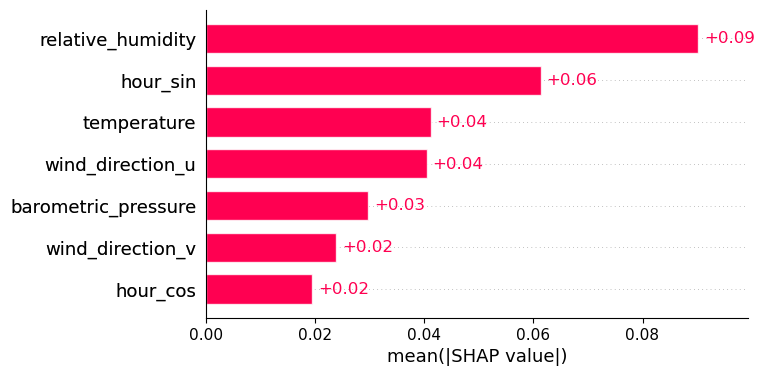

In [50]:
#análise global
explainer = shap.Explainer(rfg.predict, sample_x)
shap_values = explainer(sample_x)
shap.plots.bar(shap_values, max_display=15, show=False)

fig = plt.gcf().set_size_inches(7, 4)
#fig.patch.set_facecolor('white')
plt.show()

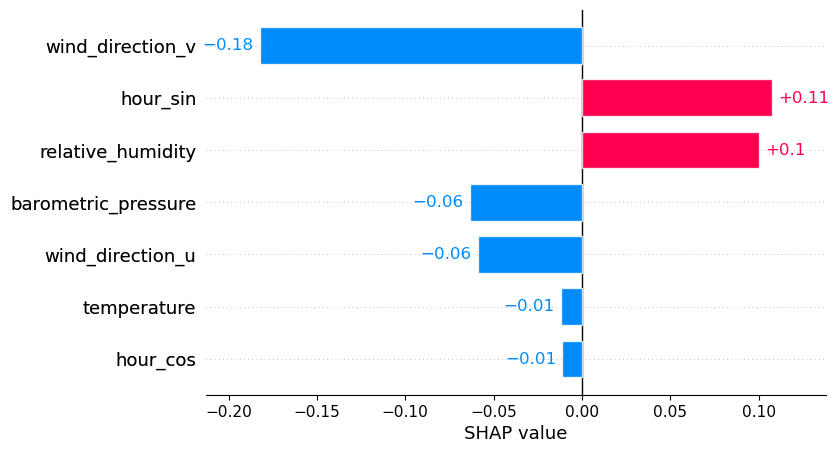

In [51]:
#análise individual de uma predição específica
shap.plots.bar(shap_values[0], max_display=15, show=False)

Mesmo assim, pra uma predição específica, a maior contribuidora foi a variável wind_direction_v.

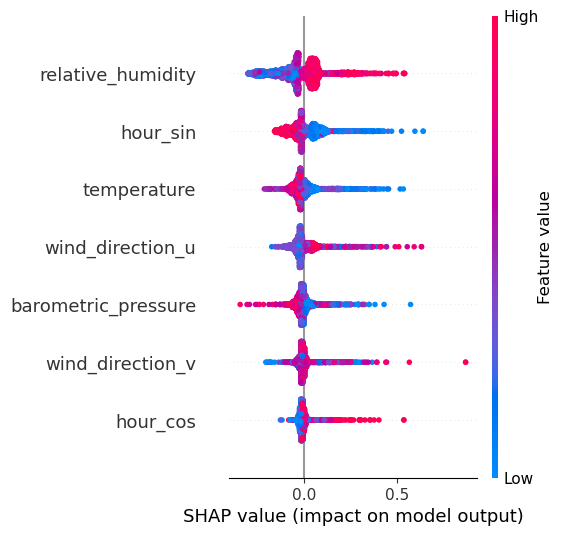

In [52]:
shap.plots.beeswarm(shap_values, show=False, plot_size=(4, 6))

Através do beeswarm percebemos que para valores altos de relative_humidity maiores são as contribuições positivas da variável.

### Conjunto 3

In [53]:
#lendo os dados

path = "../dados/A627_train.parquet.gzip"

train = pd.read_parquet(path)
val = pd.read_parquet(path)
test = pd.read_parquet(path)

In [54]:
#aplicando função de discretização
df_train = to_multi_class_columun(train, 'precipitation', 'p_padro')
df_val = to_multi_class_columun(val, 'precipitation', 'p_padro')
df_test = to_multi_class_columun(test, 'precipitation', 'p_padro')

In [55]:
#unindo treino e validação
df_train = pd.concat([df_train, df_val])

Preparação pro fit

In [56]:
#separando variáveis
target = ['p_padro']

dep_to_scaler = df_train.columns.drop(['precipitation', 'p_padro'])

In [57]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler]
X_test = df_test[dep_to_scaler]

In [58]:
X_train.shape, X_test.shape

((19430, 7), (9715, 7))

Padronização dos dados

In [59]:
#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [60]:
rfg = RandomForestClassifier(random_state=1)

rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

#### SHAP values

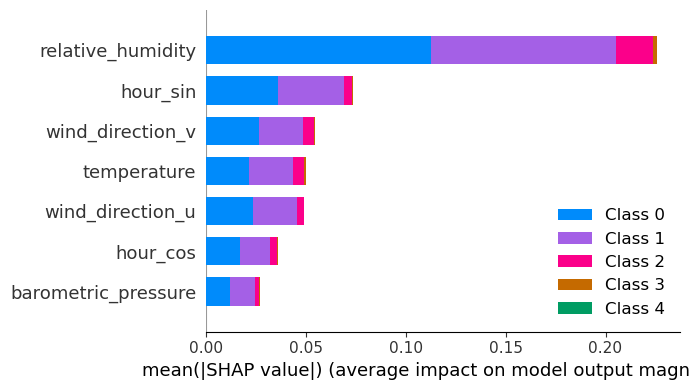

In [61]:
#análise global por classe
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=15, plot_size=(7, 4))

O gráfico acima também sugere a feature relative_humidity como vaiável mais relevante pro modelo, pois é a que apresenta mais contribuições para as classes.

In [64]:
#amostrando X para agilizar algumas análises
amostra = int(len(X_train) * 0.2)

sample_x = X_train.sample(amostra)

ExactExplainer explainer: 3887it [04:35, 13.62it/s]                          


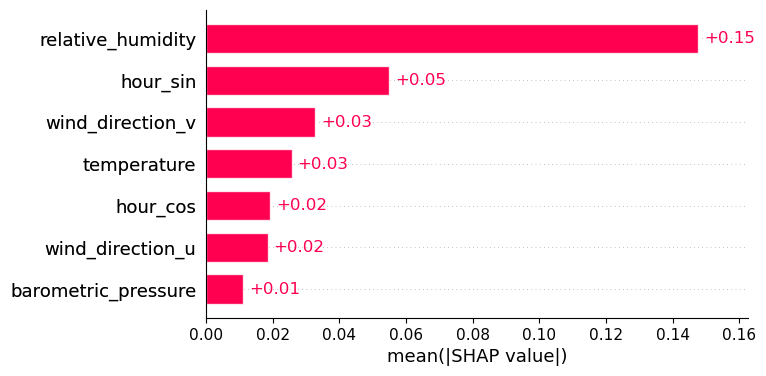

In [65]:
#análise global
explainer = shap.Explainer(rfg.predict, sample_x)
shap_values = explainer(sample_x)
shap.plots.bar(shap_values, max_display=15, show=False)

fig = plt.gcf().set_size_inches(7, 4)
#fig.patch.set_facecolor('white')
plt.show()

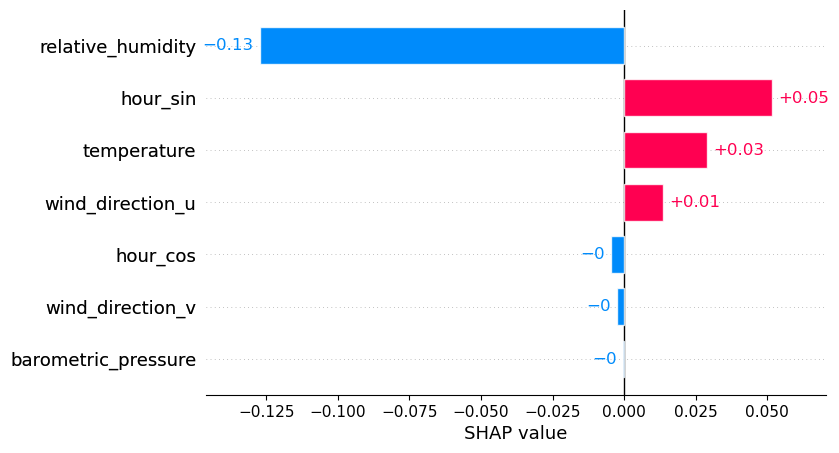

In [66]:
#análise individual de uma predição específica
shap.plots.bar(shap_values[0], max_display=15, show=False)

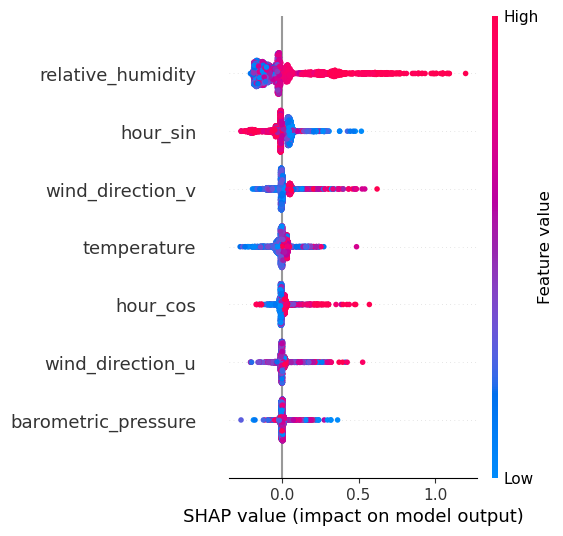

In [67]:
shap.plots.beeswarm(shap_values, show=False, plot_size=(4, 6))

Através do beeswarm percebemos que para valores altos de relative_humidity maiores são as contribuições positivas da variável.

### Conjunto 4

In [68]:
#lendo os dados

path = "../dados/A636_train.parquet.gzip"

train = pd.read_parquet(path)
val = pd.read_parquet(path)
test = pd.read_parquet(path)

In [69]:
#aplicando função de discretização
df_train = to_multi_class_columun(train, 'precipitation', 'p_padro')
df_val = to_multi_class_columun(val, 'precipitation', 'p_padro')
df_test = to_multi_class_columun(test, 'precipitation', 'p_padro')

In [70]:
#unindo treino e validação
df_train = pd.concat([df_train, df_val])

Preparação pro fit

In [71]:
#separando variáveis
target = ['p_padro']

dep_to_scaler = df_train.columns.drop(['precipitation', 'p_padro'])

In [72]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler]
X_test = df_test[dep_to_scaler]

In [73]:
X_train.shape, X_test.shape

((20504, 7), (10252, 7))

Padronização dos dados

In [74]:
#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [75]:
rfg = RandomForestClassifier(random_state=1)

rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

#### SHAP values

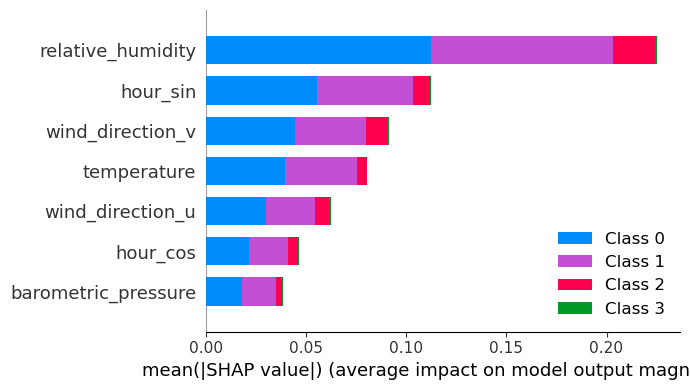

In [76]:
#análise global por classe
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=15, plot_size=(7, 4))

O gráfico acima também sugere a feature relative_humidity como vaiável mais relevante pro modelo, pois é a que apresenta mais contribuições para as classes.

In [77]:
#amostrando X para agilizar algumas análises
amostra = int(len(X_train) * 0.2)

sample_x = X_train.sample(amostra)

ExactExplainer explainer: 4101it [22:56,  2.89it/s]                              


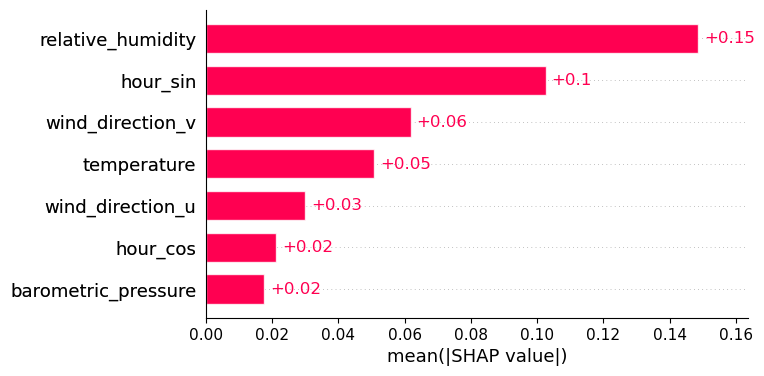

In [78]:
#análise global
explainer = shap.Explainer(rfg.predict, sample_x)
shap_values = explainer(sample_x)
shap.plots.bar(shap_values, max_display=15, show=False)

fig = plt.gcf().set_size_inches(7, 4)
#fig.patch.set_facecolor('white')
plt.show()

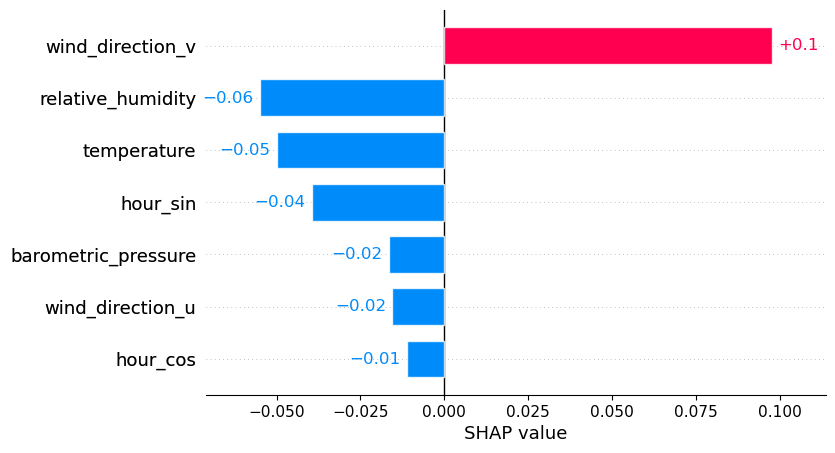

In [80]:
#análise individual de uma predição específica
shap.plots.bar(shap_values[0], max_display=15, show=False)

Mesmo assim, pra uma predição específica, a maior contribuidora foi a variável wind_direction_v, sendo a única positiva.

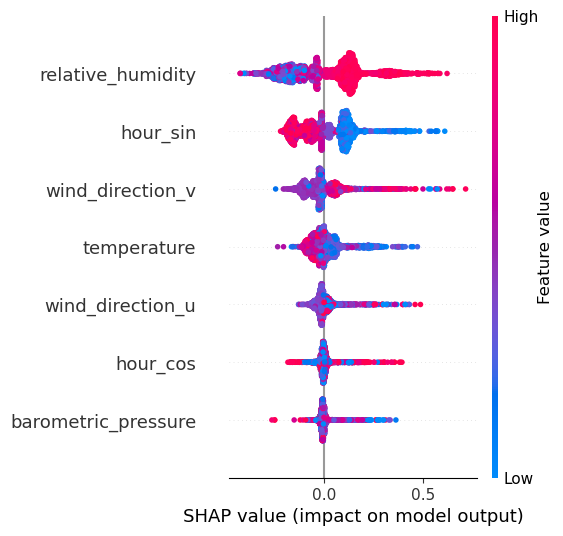

In [81]:
shap.plots.beeswarm(shap_values, show=False, plot_size=(4, 6))

Através do beeswarm percebemos que para valores altos de relative_humidity maiores são as contribuições positivas da variável.

### Conjunto 5

In [82]:
#lendo os dados

path = "../dados/A652_train.parquet.gzip"

train = pd.read_parquet(path)
val = pd.read_parquet(path)
test = pd.read_parquet(path)

In [83]:
#aplicando função de discretização
df_train = to_multi_class_columun(train, 'precipitation', 'p_padro')
df_val = to_multi_class_columun(val, 'precipitation', 'p_padro')
df_test = to_multi_class_columun(test, 'precipitation', 'p_padro')

In [84]:
#unindo treino e validação
df_train = pd.concat([df_train, df_val])

Preparação pro fit

In [85]:
#separando variáveis
target = ['p_padro']

dep_to_scaler = df_train.columns.drop(['precipitation', 'p_padro'])

In [86]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler]
X_test = df_test[dep_to_scaler]

In [87]:
X_train.shape, X_test.shape

((20118, 7), (10059, 7))

Padronização dos dados

In [88]:
#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [89]:
rfg = RandomForestClassifier(random_state=1)

rfg.fit(X_train,y_train)
y_pred = rfg.predict(X_test)

#### SHAP values

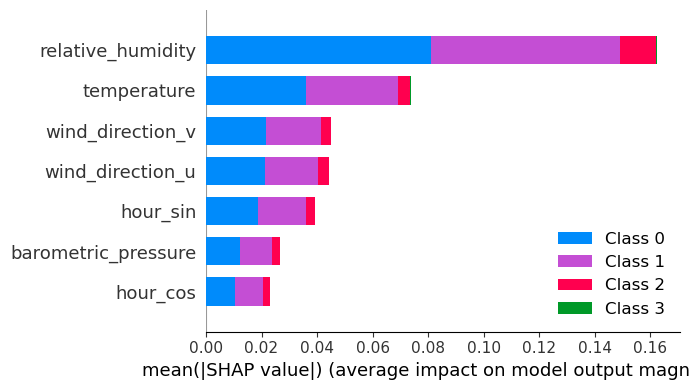

In [90]:
#análise global por classe
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=15, plot_size=(7, 4))

O gráfico acima também sugere a feature relative_humidity como vaiável mais relevante pro modelo, pois é a que apresenta mais contribuições para as classes.

In [92]:
#amostrando X para agilizar algumas análises
amostra = int(len(X_train) * 0.2)

sample_x = X_train.sample(amostra)

ExactExplainer explainer: 4024it [05:54, 10.94it/s]                            


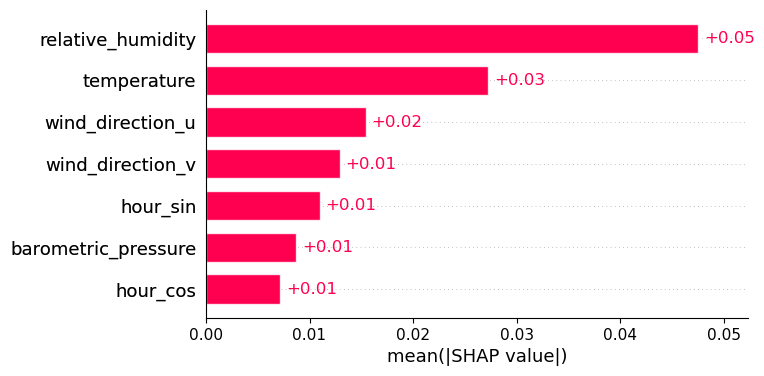

In [93]:
#análise global
explainer = shap.Explainer(rfg.predict, sample_x)
shap_values = explainer(sample_x)
shap.plots.bar(shap_values, max_display=15, show=False)

fig = plt.gcf().set_size_inches(7, 4)
#fig.patch.set_facecolor('white')
plt.show()

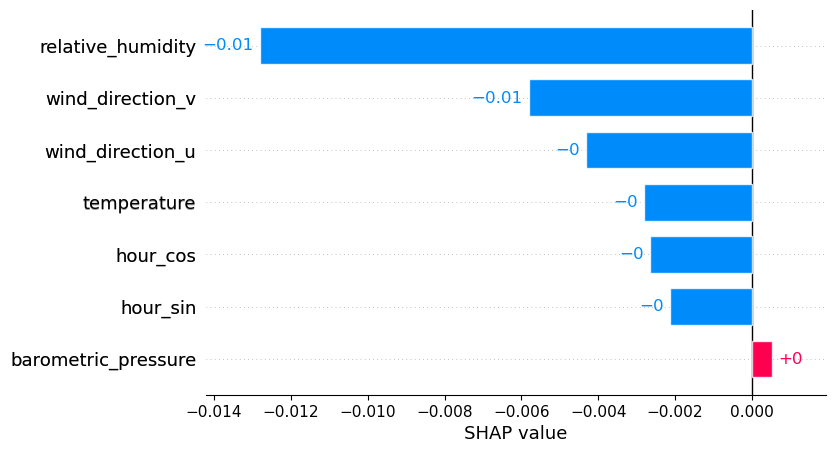

In [94]:
#análise individual de uma predição específica
shap.plots.bar(shap_values[0], max_display=15, show=False)

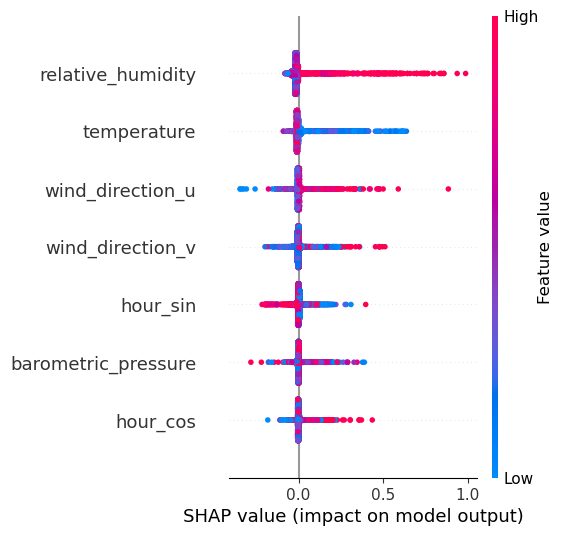

In [95]:
shap.plots.beeswarm(shap_values, show=False, plot_size=(4, 6))

Através do beeswarm percebemos que para valores altos de relative_humidity maiores são as contribuições positivas da variável.

## 5 - Redução de dimensionalidade

### Conjunto 5

In [14]:
with open("../dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [15]:
y_train = to_multi_class(y_train)
y_val = to_multi_class(y_val)
y_test = to_multi_class(y_test)

In [16]:
#unindo verticalmente arrays de treino e validação para aproveitamento máximo
X_all = np.vstack((X_train, X_val))
y_all = np.vstack((y_train, y_val))

In [18]:
#Scaler
scaler_train = StandardScaler()

#fit transform no dataset de treino e transform nos dados de teste
transformed_train = scaler_train.fit_transform(X_all)
X_all_sc = transformed_train

transformed_test = scaler_train.transform(X_test)
X_test_sc = transformed_test

O GridSearch vai fazer a busca do melhor número de componentes considerando todas as dimensões possíveis, ou seja, todas as colunas existentes em X.

In [19]:
pca = PCA()

param_grid = {'n_components': np.arange(1, X_all_sc.shape[1] + 1)}

In [20]:
#realizando a busca com cross-validation
grid_pca = GridSearchCV(estimator=pca, param_grid=param_grid, cv=5)
grid_pca.fit(X_all_sc)


GridSearchCV(cv=5, estimator=PCA(),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [21]:
#melhor estimador
grid_pca.best_estimator_

PCA(n_components=19)

In [22]:
#dimensionando dados de treino e teste com base no melhor número de componentes encontrado pelo gridsearch
best_pca = grid_pca.best_estimator_

X_all_pca = best_pca.fit_transform(X_all_sc)
X_test_pca = best_pca.transform(X_test_sc)

In [23]:
clf = GradientBoostingClassifier(random_state=1)

#treinando com X dimensionado e y preservado
clf.fit(X_all_pca,y_all)
y_pred = clf.predict(X_test_pca)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      8769
         1.0       0.60      0.17      0.27       757
         2.0       0.00      0.00      0.00        50
         3.0       0.00      0.00      0.00         4
         4.0       0.00      0.00      0.00         2

    accuracy                           0.92      9582
   macro avg       0.31      0.23      0.25      9582
weighted avg       0.90      0.92      0.90      9582



Comparando resultados com a classificação da questão 3 para o mesmo conjunto de dados, vemos uma diminuição de 1p.p. na acurácia, que foi de 93% para 92%.

## 6 - Agrupamento

### K-means

O K-Means é um método de agrupamento que agrupa dados em k clusters, onde cada dado pertence ao cluster cujo centro (centróide) é o mais próximo.

#### Conjunto 5

In [3]:
with open("../dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [4]:
#unindo verticalmente arrays de treino, validação e teste para aproveitamento máximo
X_all = np.vstack((X_train, X_val, X_test))

In [5]:
#Scaler
scaler_train = StandardScaler()

#fit transform no dataset de treino
transformed_train = scaler_train.fit_transform(X_all)
X_all_sc = transformed_train

O GridSearch vai fazer a busca da melhor combinação de hiperparâmetros para o algortimo de clusterização

In [6]:
km = KMeans(random_state=2)

param_grid = {'n_clusters': [1,2,3]
              ,'n_init': [10,15,20]
              ,'max_iter': [300,500]
              }

Importante saber:

n_clusters - número de clusters a serem formados;    
n_init - número de vezes que o algoritmo kmeans é executado com sementes centróides diferentes;   
max_iter - número máximo de iterações do algoritmo k-means para uma única execução.

In [7]:
#realizando a busca com cross-validation
grid_km = GridSearchCV(estimator=km, param_grid=param_grid, cv=5)
grid_km.fit(X_all_sc)

GridSearchCV(cv=5, estimator=KMeans(random_state=2),
             param_grid={'max_iter': [300, 500], 'n_clusters': [1, 2, 3],
                         'n_init': [10, 15, 20]})

In [8]:
#melhor estimador
grid_km.best_estimator_

KMeans(n_clusters=3, n_init=10, random_state=2)

Clusterizando usando o melhor estimador

In [9]:
best_km = grid_km.best_estimator_

#clusterizando
best_km.fit(X_all_sc)

KMeans(n_clusters=3, n_init=10, random_state=2)

Criando um novo dataset com os valores de X e cluster - que servirá de target

In [10]:
df_result = pd.DataFrame(X_all)
df_result['cluster'] = best_km.labels_
df_result['cluster_name'] = np.nan

df_result.loc[df_result.cluster == 0, 'cluster_name'] = 'none'
df_result.loc[df_result.cluster == 1, 'cluster_name'] = 'weak'
df_result.loc[df_result.cluster == 2, 'cluster_name'] = 'moderate'

df_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,cluster,cluster_name
0,0.169154,0.538776,0.763889,0.379965,0.279775,0.500000,1.000000,0.0,0.169154,0.546939,0.805556,0.317746,0.344950,0.629410,0.982963,0.0,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,0,none
1,0.169154,0.546939,0.805556,0.317746,0.344950,0.629410,0.982963,0.0,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,0,none
2,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,0,none
3,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,0.154229,0.493878,0.861111,0.458675,0.308220,0.982963,0.629410,0.0,2,moderate
4,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,0.154229,0.493878,0.861111,0.458675,0.308220,0.982963,0.629410,0.0,0.124378,0.473469,0.916667,0.451398,0.324011,1.000000,0.500000,0.0,2,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22095,0.556650,0.511278,0.500000,0.540259,0.351490,0.146447,0.146447,0.0,0.561576,0.481203,0.486111,0.512281,0.387385,0.066987,0.250000,0.0,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,1,weak
22096,0.561576,0.481203,0.486111,0.512281,0.387385,0.066987,0.250000,0.0,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,1,weak
22097,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,0.527094,0.436090,0.569444,0.535131,0.348464,0.017037,0.629410,0.0,1,weak
22098,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,0.527094,0.436090,0.569444,0.535131,0.348464,0.017037,0.629410,0.0,0.492611,0.443609,0.652778,0.531377,0.376536,0.066987,0.750000,0.0,1,weak


Separando X e novo y

In [11]:
target = ['cluster']

dep_to_scaler = df_result.select_dtypes('float').columns

In [12]:
y = df_result[target]
X = df_result[dep_to_scaler]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
X_train.shape, X_test.shape

((17680, 24), (4420, 24))

Padronizando os dados

In [15]:
#TRANFORMER DEPOIS DO SPLIT PRA NÃO VAZAR DADOS DO TREINO PRO TESTE

#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [16]:
dt = DecisionTreeClassifier(random_state = 17) 
model = dt.fit(X_train, y_train)

y_pred = model.predict(X_test)

Retornando a representação de texto das regras

In [17]:
text_representation = tree.export_text(dt, feature_names=list(X_train.columns))
print(text_representation)

|--- 22 <= 0.54
|   |--- 13 <= 0.19
|   |   |--- 0 <= -0.17
|   |   |   |--- 6 <= -1.11
|   |   |   |   |--- 10 <= -0.38
|   |   |   |   |   |--- 20 <= 0.29
|   |   |   |   |   |   |--- 8 <= -0.28
|   |   |   |   |   |   |   |--- 2 <= -1.85
|   |   |   |   |   |   |   |   |--- 12 <= -1.50
|   |   |   |   |   |   |   |   |   |--- 17 <= -0.79
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- 17 >  -0.79
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- 12 >  -1.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- 2 >  -1.85
|   |   |   |   |   |   |   |   |--- 12 <= 0.44
|   |   |   |   |   |   |   |   |   |--- 17 <= -0.20
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- 17 >  -0.20
|   |   |   |   |   |   |   |   |   |   |--- 15 <= -0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |  

Código que percorre recursivamente os nós da árvore e imprime regras de decisão para entendermos

In [18]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [19]:
rules = get_rules(dt, list(X_train.columns), np.unique(y_pred))
for r in rules:
    print(r)

if (22 <= 0.539) and (13 > 0.188) and (16 <= 1.251) and (12 <= 2.382) and (10 > -1.812) and (16 <= 0.716) and (4 <= 0.337) and (8 <= 1.226) and (7 <= 9.619) and (20 <= 1.705) and (17 <= 3.02) and (15 <= 25.773) and (10 > -1.49) and (12 <= 0.982) and (8 <= 1.039) and (15 <= 7.894) and (1 <= 2.564) and (12 <= 0.792) and (11 > -1.116) and (15 <= 1.455) and (19 > -1.01) then class: 2 (proba: 100.0%) | based on 4,192 samples
if (22 > 0.539) and (0 <= 0.918) and (14 > 0.54) and (2 > -0.819) and (17 > -1.91) and (21 > -0.846) and (4 > -1.389) and (17 > -0.85) and (12 <= 7.063) and (4 > -1.161) and (0 <= 0.851) and (19 <= 2.002) and (19 > -3.271) and (20 > -1.944) and (11 > -3.103) and (12 > -1.612) and (0 <= 0.68) then class: 0 (proba: 100.0%) | based on 3,398 samples
if (22 <= 0.539) and (13 <= 0.188) and (0 > -0.169) and (10 <= 0.434) and (19 <= 1.155) and (2 <= 0.502) and (7 <= 0.346) and (0 > 0.275) and (1 > -2.084) then class: 1 (proba: 100.0%) | based on 2,620 samples
if (22 > 0.539) an

Considerações:  

Nas regras acima é possivel visualizar de maneira mais analítica quais pontos de corte que o classificador usou nas variáveis pra classificar. Como estamos trabalhando com muitas variáveis, a árvore acaba precisando de muitos pontos de decisão e por isso precisa de muitas regras.  

Trazendo uma dela pra interpretação:

(22 <= 0.539) and (13 <= 0.188) and (0 > -0.169) and (10 <= 0.434) and (19 <= 1.155) and (2 <= 0.502) and (7 <= 0.346) and (0 > 0.275) and (1 > -2.084) then class: 1 (proba: 100.0%) | based on 2,620 samples  

Ou seja,  

Se as variáveis 22, 13, 0, 10, 19, 2, 7 e 1, juntas, atenderem a essas condições, então a instância pertencerá a classe 1 (weak).

### DBSCAN

O algoritmo DBSCAN encontra amostras centrais de alta densidade e expande clusters a partir delas, sendo bom para dados que contêm clusters de densidade semelhante.

#### Conjunto 5

In [20]:
with open("../dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [21]:
#unindo verticalmente arrays de treino, validação e teste para aproveitamento máximo
X_all = np.vstack((X_train, X_val, X_test))

In [22]:
#Scaler
scaler_train = StandardScaler()

#fit transform no dataset de treino
transformed_train = scaler_train.fit_transform(X_all)
X_all_sc = transformed_train

O GridSearch vai fazer a busca da melhor combinação de hiperparâmetros para o algortimo de clusterização

In [23]:
dbs = DBSCAN()

param_grid = {'eps': [0.2, 0.3, 0.5]
              ,'min_samples': [5,8,10]
              }

Importante saber:

eps - a distância máxima entre duas amostras para que uma seja considerada como na vizinhança do outro;    
min_samples - onúmero de amostras (ou peso total) em uma vizinhança para um ponto a ser ser considerado um ponto central e isso inclui o ponto em si;   

Usar o DBSCAN com GridSearch é mais desafiador porque não possui uma função de pontuação padrão incorporada.

In [24]:
#realizando a busca com cross-validation
grid_dbs = GridSearchCV(estimator=dbs, param_grid=param_grid, scoring='v_measure_score', cv=5)
grid_dbs.fit(X_all_sc)

GridSearchCV(cv=5, estimator=DBSCAN(),
             param_grid={'eps': [0.2, 0.3, 0.5], 'min_samples': [5, 8, 10]},
             scoring='v_measure_score')

In [25]:
#melhor estimador
grid_dbs.best_estimator_

DBSCAN(eps=0.2)

Clusterizando usando o melhor estimador

In [26]:
best_dbs = grid_dbs.best_estimator_

#clusterizando
best_dbs.fit(X_all_sc)

DBSCAN(eps=0.2)

Criando um novo dataset com os valores de X e cluster - que servirá de target

In [27]:
df_result = pd.DataFrame(X_all)
df_result['cluster'] = best_dbs.labels_

df_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,cluster
0,0.169154,0.538776,0.763889,0.379965,0.279775,0.500000,1.000000,0.0,0.169154,0.546939,0.805556,0.317746,0.344950,0.629410,0.982963,0.0,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,-1
1,0.169154,0.546939,0.805556,0.317746,0.344950,0.629410,0.982963,0.0,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,-1
2,0.154229,0.555102,0.833333,0.418706,0.316508,0.750000,0.933013,0.0,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,-1
3,0.169154,0.555102,0.833333,0.427882,0.295852,0.853553,0.853553,0.0,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,0.154229,0.493878,0.861111,0.458675,0.308220,0.982963,0.629410,0.0,-1
4,0.169154,0.534694,0.791667,0.446062,0.319531,0.933013,0.750000,0.0,0.154229,0.493878,0.861111,0.458675,0.308220,0.982963,0.629410,0.0,0.124378,0.473469,0.916667,0.451398,0.324011,1.000000,0.500000,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22095,0.556650,0.511278,0.500000,0.540259,0.351490,0.146447,0.146447,0.0,0.561576,0.481203,0.486111,0.512281,0.387385,0.066987,0.250000,0.0,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,-1
22096,0.561576,0.481203,0.486111,0.512281,0.387385,0.066987,0.250000,0.0,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,-1
22097,0.546798,0.454887,0.527778,0.494248,0.434238,0.017037,0.370590,0.0,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,0.527094,0.436090,0.569444,0.535131,0.348464,0.017037,0.629410,0.0,-1
22098,0.522167,0.439850,0.555556,0.539878,0.358731,0.000000,0.500000,0.0,0.527094,0.436090,0.569444,0.535131,0.348464,0.017037,0.629410,0.0,0.492611,0.443609,0.652778,0.531377,0.376536,0.066987,0.750000,0.0,-1


Separando X e novo y

In [28]:
target = ['cluster']

dep_to_scaler = df_result.select_dtypes('float').columns

In [29]:
y = df_result[target]
X = df_result[dep_to_scaler]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [31]:
X_train.shape, X_test.shape

((17680, 24), (4420, 24))

Padronizando os dados

In [32]:
#TRANFORMER DEPOIS DO SPLIT PRA NÃO VAZAR DADOS DO TREINO PRO TESTE

#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

In [33]:
dt = DecisionTreeClassifier(random_state = 17) 
model = dt.fit(X_train, y_train)

y_pred = model.predict(X_test)

Retornando a representação de texto das regras

In [34]:
text_representation = tree.export_text(dt, feature_names=list(X_train.columns))
print(text_representation)

|--- class: 0



Código que percorre recursivamente os nós da árvore e imprime regras de decisão para entendermos

In [35]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [36]:
rules = get_rules(dt, list(X_train.columns), np.unique(y_pred))
for r in rules:
    print(r)

if  then class: -1 (proba: 100.0%) | based on 17,680 samples


Considerações:  

No DBSCAN quando o algoritmo atribui o rótulo ao cluster -1, isso indica que o ponto é considerado um ponto de ruído ou um ponto que não se encaixa em nenhum dos clusters identificados.  

Também foram realizados testes com o DBSCAN sem passar pelo grid, porém o resultado foi o mesmo.